In [1]:
import numpy as py
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from imblearn.over_sampling import SMOTE

from matplotlib.image import imread
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout2d,\
                        LSTM, MSELoss
from torch.optim import Adam

## 

## 

In [2]:
colname = pd.read_excel('MDS_Assignment3_Steelplates.xlsx', 'Var_Name', header = None)
steel = pd.read_excel('MDS_Assignment3_Steelplates.xlsx', 'Faults', header = None)
steel.columns = colname[0].tolist()
label_df = steel.iloc[:, 27:]
new_label = label_df.idxmax(axis = 1)
done_steel = steel.iloc[:, :27]
done_steel['label'] = new_label

### a.

In [3]:
done_steel.iloc[:, :14].describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,1459.160227,0.400309,0.599691,78.737764
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,144.577823,0.490087,0.490087,55.086032
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,1227.000000,0.000000,0.000000,40.000000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,1358.000000,0.000000,0.000000,40.000000
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,1364.000000,0.000000,1.000000,70.000000
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,1650.000000,1.000000,1.000000,80.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,1794.000000,1.000000,1.000000,300.000000


In [4]:
done_steel.iloc[:, 14:-1].describe()

,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,0.331715,0.414203,0.570767,0.033361,0.610529,0.813472,0.575734,2.492388,1.335686,1.403271,0.083288,-0.131305,0.585420
std,0.299712,0.137261,0.271058,0.058961,0.243277,0.234274,0.482352,0.788930,0.481612,0.454345,0.500868,0.148767,0.339452
min,0.000000,0.000000,0.008300,0.001500,0.014400,0.048400,0.000000,0.301000,0.301000,0.000000,-0.991000,-0.998900,0.119000
25%,0.060400,0.315800,0.361300,0.006600,0.411800,0.596800,0.000000,1.924300,1.000000,1.079200,-0.333300,-0.195000,0.248200
50%,0.227300,0.412100,0.555600,0.010100,0.636400,0.947400,1.000000,2.240600,1.176100,1.322200,0.095200,-0.133000,0.506300
75%,0.573800,0.501600,0.818200,0.023500,0.800000,1.000000,1.000000,2.914900,1.518500,1.732400,0.511600,-0.066600,0.999800
max,0.995200,0.943900,1.000000,0.875900,1.000000,1.000000,1.000000,5.183700,3.074100,4.258700,0.991700,0.642100,1.000000


### b.

In [5]:
cor_matrix = done_steel.iloc[:, :-1].corr()
cor_matrix

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
X_Minimum,1.000000,0.988314,0.041821,0.041807,-0.307322,-0.258937,-0.118757,-0.339045,0.237637,-0.075554,...,-0.361160,0.154778,0.367907,0.147282,-0.428553,-0.437944,-0.326851,0.178585,-0.031578,-0.355251
X_Maximum,0.988314,1.000000,0.052147,0.052135,-0.225399,-0.186326,-0.090138,-0.247052,0.168649,-0.062392,...,-0.214930,0.149259,0.271915,0.099253,-0.332169,-0.324012,-0.265990,0.115019,-0.038996,-0.286736
Y_Minimum,0.041821,0.052147,1.000000,1.000000,0.017670,0.023843,0.024150,0.007362,-0.065703,-0.067785,...,0.054165,0.066085,-0.036543,-0.062911,0.044952,0.070406,-0.008442,-0.086497,-0.090654,0.025257
Y_Maximum,0.041807,0.052135,1.000000,1.000000,0.017840,0.024038,0.024380,0.007499,-0.065733,-0.067776,...,0.054185,0.066051,-0.036549,-0.062901,0.044994,0.070432,-0.008382,-0.086480,-0.090666,0.025284
Pixels_Areas,-0.307322,-0.225399,0.017670,0.017840,1.000000,0.966644,0.827199,0.978952,-0.497204,0.110063,...,0.588606,-0.294673,-0.463571,-0.109655,0.650234,0.603072,0.578342,-0.137604,-0.043449,0.422947
X_Perimeter,-0.258937,-0.186326,0.023843,0.024038,0.966644,1.000000,0.912436,0.912956,-0.400427,0.111363,...,0.517098,-0.293039,-0.412100,-0.079106,0.563036,0.524716,0.523472,-0.101731,-0.032617,0.380605
Y_Perimeter,-0.118757,-0.090138,0.024150,0.024380,0.827199,0.912436,1.000000,0.704876,-0.213758,0.061809,...,0.209160,-0.195162,-0.136723,0.013438,0.294040,0.228485,0.344378,0.031381,-0.047778,0.191772
Sum_of_Luminosity,-0.339045,-0.247052,0.007362,0.007499,0.978952,0.912956,0.704876,1.000000,-0.540566,0.136515,...,0.658339,-0.327728,-0.529745,-0.121090,0.712128,0.667736,0.618795,-0.158483,-0.014067,0.464248
Minimum_of_Luminosity,0.237637,0.168649,-0.065703,-0.065733,-0.497204,-0.400427,-0.213758,-0.540566,1.000000,0.429605,...,-0.487574,0.252256,0.316610,0.035462,-0.678762,-0.567655,-0.588208,0.057123,0.669534,-0.514797
Maximum_of_Luminosity,-0.075554,-0.062392,-0.067785,-0.067776,0.110063,0.111363,0.061809,0.136515,0.429605,1.000000,...,0.099300,0.093522,-0.167441,-0.124039,0.007672,0.092823,-0.069522,-0.169747,0.870160,-0.039651


### c.

In [6]:
X = done_steel.iloc[:, :-1]
Y = done_steel.label
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.25)

clf = DecisionTreeClassifier(max_depth = 10, min_samples_split = 5)
f1_micro = cross_val_score(clf, X, Y, cv = 10, scoring = 'f1_micro')
auc_ovo = cross_val_score(clf, X, Y, cv = 10, scoring = 'roc_auc_ovo')
accuracy = cross_val_score(clf, X, Y, cv = 10, scoring = 'accuracy')
print('f1:', np.mean(f1_micro), '\nauc:', np.mean(auc_ovo), '\naccuracy:', np.mean(accuracy))

f1: 0.5802088289717154 
auc: 0.853657652969326 
accuracy: 0.5827755749405235


### d.

In [7]:
smote = SMOTE(sampling_strategy = 'not majority')
smote_X, smote_Y = smote.fit_resample(X, Y)
smote_steel = pd.concat([smote_X, smote_Y], axis = 1)

### e.

In [8]:
clf = DecisionTreeClassifier(max_depth = 10, min_samples_split = 5)
f1_micro = cross_val_score(clf, smote_X, smote_Y, cv = 10, scoring = 'f1_micro')
auc_ovo = cross_val_score(clf, smote_X, smote_Y, cv = 10, scoring = 'roc_auc_ovo')
accuracy = cross_val_score(clf, smote_X, smote_Y, cv = 10, scoring = 'accuracy')
print('f1:', np.mean(f1_micro), '\nauc:', np.mean(auc_ovo), '\naccuracy:', np.mean(accuracy))

f1: 0.8217019324193027 
auc: 0.9380556532003077 
accuracy: 0.8193664759437187


### g.

In [9]:
clf = RandomForestClassifier(n_estimators = 200)
f1_micro = cross_val_score(clf, X, Y, cv = 10, scoring = 'f1_micro')
auc_ovo = cross_val_score(clf, X, Y, cv = 10, scoring = 'roc_auc_ovo')
accuracy = cross_val_score(clf, X, Y, cv = 10, scoring = 'accuracy')
print('Before SMOTE:', '\nf1:', np.mean(f1_micro), '\nauc:', np.mean(auc_ovo), '\naccuracy:', np.mean(accuracy))
f1_micro = cross_val_score(clf, smote_X, smote_Y, cv = 10, scoring = 'f1_micro')
auc_ovo = cross_val_score(clf, smote_X, smote_Y, cv = 10, scoring = 'roc_auc_ovo')
accuracy = cross_val_score(clf, smote_X, smote_Y, cv = 10, scoring = 'accuracy')
print('\nAfter SMOTE:', '\nf1:', np.mean(f1_micro), '\nauc:', np.mean(auc_ovo), '\naccuracy:', np.mean(accuracy))

Before SMOTE: 
f1: 0.6487126619085382 
auc: 0.9210999092099426 
accuracy: 0.6502590536611155

After SMOTE: 
f1: 0.8860214473352765 
auc: 0.9820417624203113 
accuracy: 0.8828349346863866


### h.

In [10]:
clf = GradientBoostingClassifier(n_estimators = 200)
f1_micro = cross_val_score(clf, X, Y, cv = 10, scoring = 'f1_micro')
auc_ovo = cross_val_score(clf, X, Y, cv = 10, scoring = 'roc_auc_ovo')
accuracy = cross_val_score(clf, X, Y, cv = 10, scoring = 'accuracy')
print('Before SMOTE:', '\nf1:', np.mean(f1_micro), '\nauc:', np.mean(auc_ovo), '\naccuracy:', np.mean(accuracy))
f1_micro = cross_val_score(clf, smote_X, smote_Y, cv = 10, scoring = 'f1_micro')
auc_ovo = cross_val_score(clf, smote_X, smote_Y, cv = 10, scoring = 'roc_auc_ovo')
accuracy = cross_val_score(clf, smote_X, smote_Y, cv = 10, scoring = 'accuracy')
print('\nAfter SMOTE:', '\nf1:', np.mean(f1_micro), '\nauc:', np.mean(auc_ovo), '\naccuracy:', np.mean(accuracy))

Before SMOTE: 
f1: 0.644588950568332 
auc: 0.916043048463439 
accuracy: 0.6363494581020354

After SMOTE: 
f1: 0.8667053510381807 
auc: 0.9789219235254807 
accuracy: 0.8658569937745153


## 

In [11]:
class CNN(Module):
    
    def __init__(self, layer):
        super(CNN, self).__init__()
        self.layer = layer
        
        self.cnn_layers = Sequential(
            Conv2d(3, 8, kernel_size = 5, stride = 2, padding = 1),
            Dropout2d(0.2),
            ReLU(inplace = True),
            MaxPool2d(kernel_size = 2, stride = 2),
            BatchNorm2d(8),
            Conv2d(8, 16, kernel_size = 5, stride = 2, padding = 1),
            Dropout2d(0.2),
            ReLU(inplace = True),
            MaxPool2d(kernel_size = 2, stride = 2), 
            BatchNorm2d(16)
        )
        
        self.nn_layers = Sequential(
            Linear(52*52, 128),
            ReLU(),
            Linear(128, 2)
        )
        
        self.cnn_layer = Sequential(
            Conv2d(3, 16, kernel_size = 5, stride = 2, padding = 1),
            Dropout2d(0.2),
            ReLU(inplace = True),
            MaxPool2d(kernel_size = 2, stride = 2),
            BatchNorm2d(16)
        )
        
        self.nn_layer = Sequential(
            Linear(52*52, 128),
            ReLU(),
            Linear(128, 2)
        )
        
    def forward(self, x):
        
        if self.layer == 2:
            x = self.cnn_layers(x)
            x = torch.flatten(x, 1)
            x = self.nn_layers(x)
        elif self.layer == 1:
            x = self.cnn_layer(x)
            x = torch.flatten(x, 1)
            x = self.nn_layer(x)
        
        return x

In [55]:
def training(n_epoch, trainloader, validloader):
    
    best_model = model
    best_f1 = 0
    model.train()
    train_loss = []
    valid_loss = []
    for epoch in range(n_epoch):
        
        run_loss = 0
        for i, data in enumerate(trainloader):
            
            images, labels = data
            images = images.float()
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
        train_loss.append(run_loss)
        
        if (epoch % 5) != 0:
            print(f'Epoch {epoch+1}:', ' train loss = ', run_loss) 
        elif (epoch % 5) == 0:
            test_loss, test_f1 = testing(best_model, validloader)
            valid_loss.append(test_loss)
            if test_f1 > best_f1:
                best_f1 = test_f1
                best_model = model
                print('Model Saved.')
            print(f'Epoch {epoch+1}:', ' train loss = ', run_loss, ', valid loss = ', test_loss)
    
    return best_model, train_loss, valid_loss


def testing(best_model, testloader):
    
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    test_loss = 0
    
    with torch.no_grad():
        for i, data in enumerate(testloader):
            images, labels = data
            images = images.float()
            labels = labels.long()
            outputs = best_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predict = torch.max(outputs.data, 1)
            TP += ((predict+labels) == 0).sum().item()
            TN += ((predict*labels) == 1).sum().item()
            FN += (predict > labels).sum().item()
            FP += (predict < labels).sum().item()
        
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        f1 = (recall*precision) / (recall + precision)
        
        return f1, test_loss

In [56]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
folder_path = 'C:/Users/user/Desktop/Darui_R08621110/Master_Thesis/AUO aging test/Full_Version_Code/casting_data/'
train_set = datasets.ImageFolder(folder_path + 'train/', transform = transform)
test_set = datasets.ImageFolder(folder_path + 'test/', transform = transform)
train_num = int(len(train_set)*0.8)
valid_num = len(train_set) - train_num
valid_set, train_set = random_split(train_set, [valid_num, train_num])
trainloader = DataLoader(train_set, batch_size = 32, shuffle = True)
validloader = DataLoader(valid_set, batch_size = 32, shuffle = False)
testloader = DataLoader(test_set, batch_size = 32, shuffle = False)

### a.

Model Saved.
Epoch 1:  train loss =  117.19030052423477 , valid loss =  0.3935212957408519
Epoch 2:  train loss =  73.25091370940208
Epoch 3:  train loss =  58.72906431555748
Epoch 4:  train loss =  53.774940103292465
Epoch 5:  train loss =  55.27946396917105
Epoch 6:  train loss =  54.60655886679888 , valid loss =  0.4262975778546713
Epoch 7:  train loss =  51.26944641023874
Epoch 8:  train loss =  50.47945887595415
Epoch 9:  train loss =  49.97801795974374
Epoch 10:  train loss =  47.216190464794636
Epoch 11:  train loss =  45.42799746245146 , valid loss =  0.43134435657800135
Epoch 12:  train loss =  47.90984535962343
Epoch 13:  train loss =  47.999336034059525
Epoch 14:  train loss =  47.75370369851589
Epoch 15:  train loss =  43.23231352865696
Epoch 16:  train loss =  46.91892350465059 , valid loss =  0.4438573315719947
Epoch 17:  train loss =  44.827039524912834
Epoch 18:  train loss =  43.40721496194601
Epoch 19:  train loss =  45.728066235780716
Epoch 20:  train loss =  42.7951

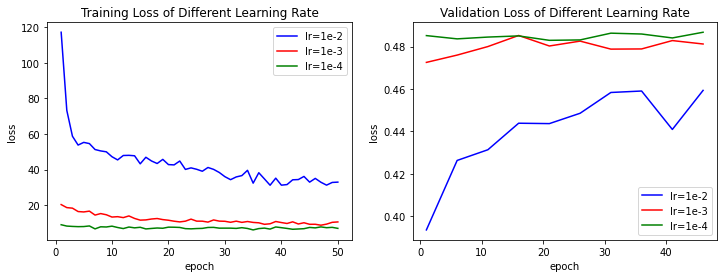

In [62]:
##### experiment 1 #####
model = CNN(layer = 2)
criterion = CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr = 0.01, weight_decay = 0.001)
lr1_model, lr1_loss, lr1_validloss = training(50, trainloader, validloader)
lr1_f1, lr1_testloss = testing(lr1_model, testloader)
print('Learning Rate = 0.01, f1 = ', lr1_f1, ', test loss = ', lr1_testloss)

optimizer = Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)
lr2_model, lr2_loss, lr2_validloss = training(50, trainloader, validloader)
lr2_f1, lr2_testloss = testing(lr2_model, testloader)
print('Learning Rate = 0.001, f1 = ', lr2_f1, ', test loss = ', lr2_testloss)

optimizer = Adam(model.parameters(), lr = 0.0001, weight_decay = 0.001)
lr3_model, lr3_loss, lr3_validloss = training(50, trainloader, validloader)
lr3_f1, lr3_testloss = testing(lr3_model, testloader)
print('Learning Rate = 0.0001, f1 = ', lr3_f1, ', test loss = ', lr3_testloss)

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(range(1, 51), lr1_loss, 'b-', label = 'lr=1e-2')
ax[0].plot(range(1, 51), lr2_loss, 'r-', label = 'lr=1e-3')
ax[0].plot(range(1, 51), lr3_loss, 'g-', label = 'lr=1e-4')
ax[0].set_title('Training Loss of Different Learning Rate')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(range(1, 51, 5), lr1_validloss, 'b-', label = 'lr=1e-2')
ax[1].plot(range(1, 51, 5), lr2_validloss, 'r-', label = 'lr=1e-3')
ax[1].plot(range(1, 51, 5), lr3_validloss, 'g-', label = 'lr=1e-4')
ax[1].set_title('Validation Loss of Different Learning Rate')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend()

Model Saved.
Epoch 1:  train loss =  71.06646655499935 , valid loss =  0.43245125348189417
Epoch 2:  train loss =  48.96430043131113
Epoch 3:  train loss =  36.83716041594744
Epoch 4:  train loss =  29.166665453463793
Epoch 5:  train loss =  26.857804216444492
Epoch 6:  train loss =  24.31307178363204 , valid loss =  0.47473404255319157
Epoch 7:  train loss =  20.385767558589578
Epoch 8:  train loss =  20.34549242258072
Epoch 9:  train loss =  20.350133527070284
Epoch 10:  train loss =  18.011212546378374
Epoch 11:  train loss =  17.746007151901722 , valid loss =  0.48342175066313
Epoch 12:  train loss =  17.14632506482303
Epoch 13:  train loss =  16.223264728672802
Epoch 14:  train loss =  15.54832524806261
Epoch 15:  train loss =  32.83725157380104
Epoch 16:  train loss =  26.4556648042053 , valid loss =  0.47054886211512714
Epoch 17:  train loss =  25.64511639997363
Epoch 18:  train loss =  25.73823731020093
Epoch 19:  train loss =  19.425052220001817
Epoch 20:  train loss =  20.308

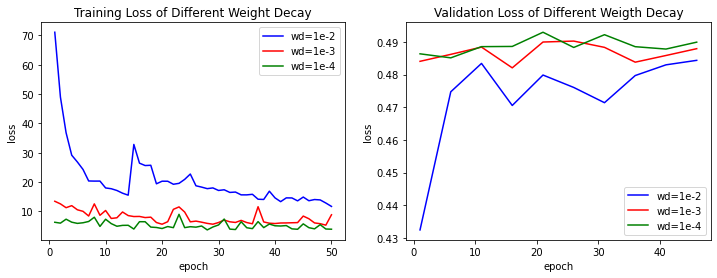

In [63]:
##### experiment 2 #####
model = CNN(layer = 2)
criterion = CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr = 0.001, weight_decay = 0.01)
wd1_model, wd1_loss, wd1_validloss = training(50, trainloader, validloader)
wd1_f1, wd1_testloss = testing(wd1_model, testloader)
print('Weight Decay = 0.01, f1 = ', wd1_f1, ', test loss = ', wd1_testloss)

optimizer = Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)
wd2_model, wd2_loss, wd2_validloss = training(50, trainloader, validloader)
wd2_f1, wd2_testloss = testing(wd2_model, testloader)
print('Weight Decay = 0.001, f1 = ', wd2_f1, ', test loss = ', wd2_testloss)

optimizer = Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001)
wd3_model, wd3_loss, wd3_validloss = training(50, trainloader, validloader)
wd3_f1, wd3_testloss = testing(wd3_model, testloader)
print('Weight Decay = 0.0001, f1 = ', wd3_f1, ', test loss = ', wd3_testloss)

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(range(1, 51), wd1_loss, 'b-', label = 'wd=1e-2')
ax[0].plot(range(1, 51), wd2_loss, 'r-', label = 'wd=1e-3')
ax[0].plot(range(1, 51), wd3_loss, 'g-', label = 'wd=1e-4')
ax[0].set_title('Training Loss of Different Weight Decay')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(range(1, 51, 5), wd1_validloss, 'b-', label = 'wd=1e-2')
ax[1].plot(range(1, 51, 5), wd2_validloss, 'r-', label = 'wd=1e-3')
ax[1].plot(range(1, 51, 5), wd3_validloss, 'g-', label = 'wd=1e-4')
ax[1].set_title('Validation Loss of Different Weigth Decay')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend()

Model Saved.
Epoch 1:  train loss =  74.41806651651859 , valid loss =  0.41833810888252154
Epoch 2:  train loss =  43.33051173388958
Epoch 3:  train loss =  34.44213543832302
Epoch 4:  train loss =  28.56118242070079
Epoch 5:  train loss =  26.55361833702773
Epoch 6:  train loss =  26.2282833494246 , valid loss =  0.4675409836065574
Epoch 7:  train loss =  22.58572953939438
Epoch 8:  train loss =  23.397622548043728
Epoch 9:  train loss =  20.01509903371334
Epoch 10:  train loss =  17.17512495070696
Epoch 11:  train loss =  16.860213429667056 , valid loss =  0.4790540540540541
Epoch 12:  train loss =  15.885492831468582
Epoch 13:  train loss =  14.401689514517784
Epoch 14:  train loss =  22.150303482078016
Epoch 15:  train loss =  16.369592332281172
Epoch 16:  train loss =  15.522571195848286 , valid loss =  0.47859116022099446
Epoch 17:  train loss =  14.956797846592963
Epoch 18:  train loss =  14.207338429288939
Epoch 19:  train loss =  14.206123800482601
Epoch 20:  train loss =  11.

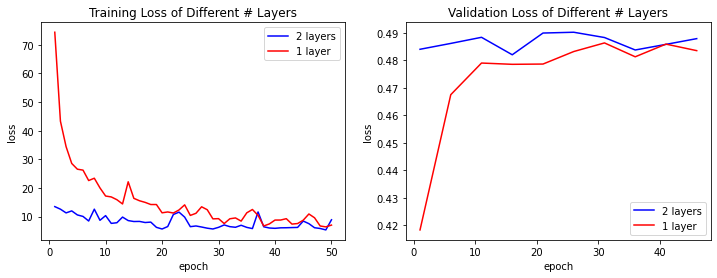

In [64]:
##### experiment 3 #####
model = CNN(layer = 1)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)
one_model, one_loss, one_validloss = training(50, trainloader, validloader)
one_f1, one_testloss = testing(one_model, testloader)

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(range(1, 51), wd2_loss, 'b-', label = '2 layers')
ax[0].plot(range(1, 51), one_loss, 'r-', label = '1 layer')
ax[0].set_title('Training Loss of Different # Layers')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(range(1, 51, 5), wd2_validloss, 'b-', label = '2 layers')
ax[1].plot(range(1, 51, 5), one_validloss, 'r-', label = '1 layer')
ax[1].set_title('Validation Loss of Different # Layers')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend()

## 

In [123]:
hpqus = pd.read_csv('Stocks/hpq.us.txt', delimiter = ',')
hpqus = hpqus.sort_values('Date')
hpqus = hpqus.drop(columns = ['Date', 'OpenInt'])

In [3]:
high_price = hpqus.High.to_numpy()
low_price = hpqus.Low.to_numpy()
mid_price = (high_price+low_price)/2
hpqus['Mid'] = mid_price
data = hpqus.copy()

scaler = MinMaxScaler()
smoothing_size = 2500

for i, j in enumerate(range(0, len(data), smoothing_size)):
    if i == len(range(0, len(data), smoothing_size)):
        data.loc[i*smoothing_size:] = scaler.fit_transform(data.loc[i*smoothing_size:])
    else:
        data.loc[i*smoothing_size: (i+1)*smoothing_size] = scaler.fit_transform(data.loc[i*smoothing_size:(i+1)*smoothing_size])
target_data = data.Mid

In [52]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


X, Y = sliding_windows(target_data, 10)
train_x = torch.tensor(X[:11000]).view(11000, 1, 10).float()
test_x = torch.tensor(X[11000:]).view(1064, 1, 10).float()
train_y = torch.tensor(Y[:11000]).view(11000, 1, 1).float()
test_y = torch.tensor(Y[11000:]).view(1064, 1, 1).float()

### a.

In [124]:
class LSTM(Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = 10
        
        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size)
        self.fc = Linear(hidden_size, 1)

    def forward(self, x):
        
        h_0 = torch.zeros(1, x.size(1), self.hidden_size).float()
        c_0 = torch.zeros(1, x.size(1), self.hidden_size).float()
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0)) 
        #h_out = h_out.view(-1, self.hidden_size)  
        out = self.fc(ula)
        
        return out

In [125]:
input_size = 10
hidden_size = 32
num_layers = 2

lstm = LSTM(input_size, hidden_size, num_layers)
criterion = MSELoss()  
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001)

loss_list = []
for epoch in range(120):
    
    outputs = lstm(train_x)
    optimizer.zero_grad()
    loss = criterion(outputs, train_y)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    print("Epoch %d: loss = %1.5f" % (epoch+1, loss.item()))

Epoch 1: loss = 0.35669
Epoch 2: loss = 0.33627
Epoch 3: loss = 0.31666
Epoch 4: loss = 0.29777
Epoch 5: loss = 0.27956
Epoch 6: loss = 0.26197
Epoch 7: loss = 0.24494
Epoch 8: loss = 0.22844
Epoch 9: loss = 0.21241
Epoch 10: loss = 0.19682
Epoch 11: loss = 0.18164
Epoch 12: loss = 0.16681
Epoch 13: loss = 0.15234
Epoch 14: loss = 0.13820
Epoch 15: loss = 0.12438
Epoch 16: loss = 0.11090
Epoch 17: loss = 0.09777
Epoch 18: loss = 0.08504
Epoch 19: loss = 0.07275
Epoch 20: loss = 0.06100
Epoch 21: loss = 0.04988
Epoch 22: loss = 0.03951
Epoch 23: loss = 0.03005
Epoch 24: loss = 0.02166
Epoch 25: loss = 0.01453
Epoch 26: loss = 0.00884
Epoch 27: loss = 0.00477
Epoch 28: loss = 0.00242
Epoch 29: loss = 0.00182
Epoch 30: loss = 0.00281
Epoch 31: loss = 0.00499
Epoch 32: loss = 0.00774
Epoch 33: loss = 0.01032
Epoch 34: loss = 0.01216
Epoch 35: loss = 0.01298
Epoch 36: loss = 0.01278
Epoch 37: loss = 0.01177
Epoch 38: loss = 0.01023
Epoch 39: loss = 0.00845
Epoch 40: loss = 0.00670
Epoch 41:

In [105]:
test_output = lstm(test_x)
predict = test_output.detach().numpy().reshape(len(test_output))*(np.max(mid_price) - np.min(mid_price))
truth = test_y.numpy().reshape(len(test_y))*(np.max(mid_price) - np.min(mid_price))
MAE = np.mean(np.abs(predict - truth))
MSE = np.mean(np.square(predict - truth))
print(f'MAE = ', MAE, ', MSE = ', MSE)

MAE =  0.53722775 , MSE =  0.49906507


### b.

Text(0, 0.5, 'loss')

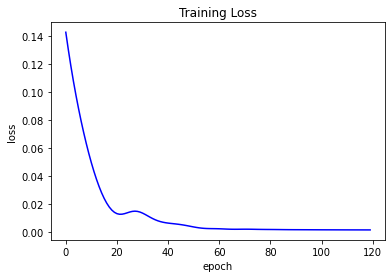

In [61]:
plt.plot(range(len(loss_list)), loss_list, 'b-')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'prediction')

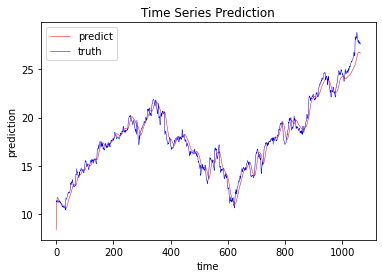

In [122]:
plt.plot(predict, label = 'predict', color = 'red', linewidth = 0.5)
plt.plot(truth, label = 'truth', color = 'blue', linewidth = 0.5)
plt.legend()
plt.title('Time Series Prediction')
plt.xlabel('time')
plt.ylabel('prediction')